**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. B. Keith Jenkins (jenkins@sipi.usc.edu)

**Notebook**: Written by Prof. Keith Chugg.

# Perceptron Leaning
In this notebook, we will use the gradient decent perceptron learning algorithm to train a linear binary classifier.  

We can initialize it with the nearest means classifier and see if it can learn a decision boundary that will separate the data.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from utils.previous_notebooks import generate_colored_nongaussian_data, solve_plot_ls_nm_classifier

From the `least_squares_binary_classifier` notebook, we know that data with directional preference can cause problems for the nearest means classifier.  Let's generate some data that is linearly spearable, but for with the nearest means classifier makes classifiaction errors.  

Note: you may have to generat this data a few times to get linearly separable data.  You may also want to try changing some of the parameters so that the data is not linearly separable to see what happens.

[[  9.19308542   3.83707636]
 [  4.91658058  -1.69703725]
 [  4.60488495   0.31609396]
 [  4.12974132  -1.38734412]
 [ 11.39845526   6.22519335]
 [  3.48788109  -3.79695121]
 [  1.68133177   0.4520679 ]
 [  4.95256914  -0.90250054]
 [  3.21475368  -0.39910123]
 [  6.5338289    3.01865185]
 [  7.11959323   1.69726369]
 [  2.74152786  -1.285954  ]
 [ 10.76813549   2.34827174]
 [ -2.72268024  -6.90222704]
 [  7.58052933   2.97205449]
 [  0.2435675   -5.77755029]
 [ -0.81430751  -4.539614  ]
 [  7.07901805   1.2128073 ]
 [ 14.50526187   8.52639236]
 [  2.78541161  -2.76396367]
 [  7.23196681   1.3963125 ]
 [  2.77705595  -1.52013842]
 [ -2.06304168  -6.90757155]
 [  6.64190126   1.04377654]
 [  5.5044158    1.19581356]
 [ -2.18866992  -6.37175606]
 [  4.54706048  -0.60477343]
 [  4.43372257  -0.82883493]
 [ -3.76903896  -8.13339611]
 [  4.85084326  -0.83763689]
 [-10.0339714   -3.32518561]
 [ -5.50869151  -2.97257854]
 [ -5.98026237  -3.22884461]
 [ -4.11005895  -0.31603974]
 [ -2.14639825

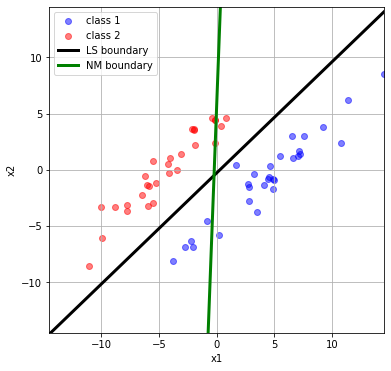

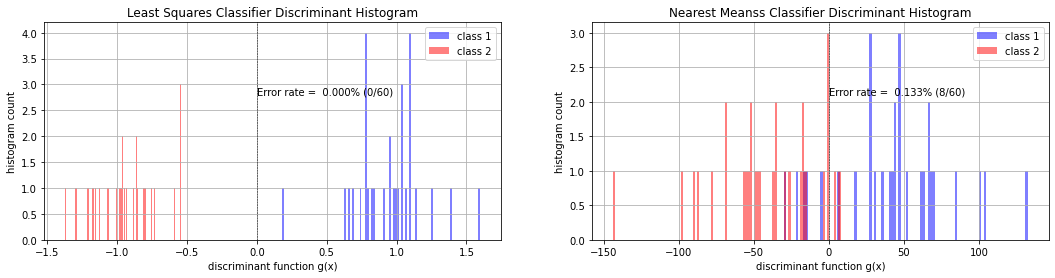

In [4]:
means = np.asarray( [ [5, 0], [-5, 0] ])
lambdas = np.asarray( [ [30, 1], [30, 1] ])  
thetas = np.asarray([ np.pi / 4, np.pi / 4 ])
Ns = np.asarray([30, 30])

x, labels, sample_means = generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal')

w_ls, w_nm = solve_plot_ls_nm_classifier(x, labels)

print(x)

Let's implement the perceptron learning algorithm.  Notice that this routine uses gradient descent with the full gradient (not serial or batch-based).  Further, note that it keeps track of the loss, the misclassification rate, and the ${\bf w}$ vector at each epoch so we can plot the learning curves and the evolution of the decision boundary with epochs.

In [7]:
def perceptron_learning(x, labels, w_int, eta=1, max_epochs=40):
    """
    x: (N, D) data array, non-augmented format
    labels:  lengnth array with labels 1, 2
    eta: learning rate (constant)
    max_epochs: max number of passes through the data.  Halts sooner if no classififcation errors
    """
    w_hat = np.copy(w_int)
    z = (-1.0) ** (labels + 1) ## (-1)^(1 + 1) = +1 and (-1)^(2+1) = -1, maps class 1 and class 2 to +1, -1, resp.
    N, D = x.shape
    x_aug = np.ones((N, D + 1))
    x_aug[:, 1:] = x
    zx = (x_aug.T * z).T

    w_hats = np.zeros((max_epochs + 1, D + 1))
    Js = np.zeros(max_epochs + 1)
    error_rates = np.zeros(max_epochs + 1)
    not_done = True
    epoch = 0
    updates_this_epoch = 1
    while not_done:
        reached_max_epochs = epoch == max_epochs
        if not updates_this_epoch or reached_max_epochs:
                not_done = False
        g_zx = zx @ w_hat
        update_indices = g_zx <= 0
        updates_this_epoch = np.sum(update_indices)
        w_hats[epoch] = np.copy(w_hat)
        Js[epoch] = - np.sum(g_zx[update_indices])
        error_rates[epoch] = updates_this_epoch
        print(f'epoch {epoch}\terrors: {updates_this_epoch}\tJ: {Js[epoch]}\tw_hat:{w_hat}')
        w_hat += eta * np.sum(zx[update_indices], axis=0)
        epoch += 1
    error_rates = error_rates / N
    if reached_max_epochs:
        epoch += 1

    return w_hats[:epoch-1], Js[:epoch-1], error_rates[:epoch-1]


Below is a generic routine to plot the evolution of the decision boundaries, the **learning curve** ($J({\bf w})$ vs. epoch), and the watch-metric for the learning curve (error rate).  Note that it is common to track another metric, the error rate in this case, that is not the loss function used for learning.  

In [6]:
def plot_linear_learning(x, labels, w_hats, Js, error_rates):
    """
    x: (N, D) data array, non-augmented format
    labels:  lengnth array with labels 1, 2
    Js: length N_epochs of Loss values (the learning curve)
    error_rates: length N_epochs of misclassification rates as the algorithm learned
    """
    N_epochs = len(Js)
    x_1 = x[labels==1]
    x_2 = x[labels==2]

    fig, ax = plt.subplots(1, 2, sharex=False, figsize=(12, 6))

    ## scatter plot with deciscion boundaries
    LIMIT = np.max(x)
    x_plot = np.arange(-1 * LIMIT, LIMIT, 0.01)
    ax[0].scatter(x_1.T[0], x_1.T[1], fc=(0, 0, 1, 0.5), label='class 1')
    ax[0].scatter(x_2.T[0], x_2.T[1], fc=(1, 0, 0, 0.5), label='class 2')
    for epoch, w_hat in enumerate(w_hats):
        ax[0].plot( x_plot, -1 * ( w_hat[1] *  x_plot  + w_hat[0] ) / w_hat[2], linewidth=2, label=f'epoch {epoch}')
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].set_xlim([-LIMIT, LIMIT])
    ax[0].set_ylim([-LIMIT, LIMIT])
    ax[0].legend()
    ax[0].grid(':')

    ## Learning curve
    epochs = np.arange(N_epochs)
    ax[1].plot(epochs, Js, marker='o', color='green', label='J (Loss)')
    # add second y-axis for the metric of error rate: https://pythonguides.com/matplotlib-two-y-axes/
    ax2 = ax[1].twinx() 
    ax2.plot(epochs, error_rates * 100, marker='x', color='purple', label='Error Rate')
    ax[1].set_ylabel('J (Loss)', color = 'green') 
    ax[1].tick_params(axis ='y', labelcolor = 'green') 
    ax2.set_ylabel('Error rate (%)', color = 'purple') 
    ax2.tick_params(axis ='y', labelcolor = 'purple') 

    # ax[1].set_xlabel('epoch')
    # ax[1].set_ylabel('J (Loss)')
    ax2.set_ylabel('error rate (%)')
    ax[0].legend()
    ax[1].grid(':')


Let's try it with learning rate $\eta =1$:

epoch 0	errors: 8	J: 98.22023591014192	w_hat:[ 1.86558957  9.20068603 -0.33640144]
epoch 1	errors: 29	J: 4553.194277149849	w_hat:[  3.86558957  -3.47787337 -44.03427963]
epoch 2	errors: 12	J: 5163.1106448379505	w_hat:[  0.86558957 216.71404407  41.71250526]
epoch 3	errors: 7	J: 1741.2336159304305	w_hat:[  0.86558957 205.0018958  -21.21643209]
epoch 4	errors: 3	J: 317.2047575415996	w_hat:[  3.86558957 192.21450712 -62.58099964]
epoch 5	errors: 1	J: 1.7708976388033761	w_hat:[  6.86558957 183.53411799 -83.98837886]
epoch 6	errors: 0	J: -0.0	w_hat:[  7.86558957 179.76507903 -92.12177497]
epoch 7	errors: 0	J: -0.0	w_hat:[  7.86558957 179.76507903 -92.12177497]


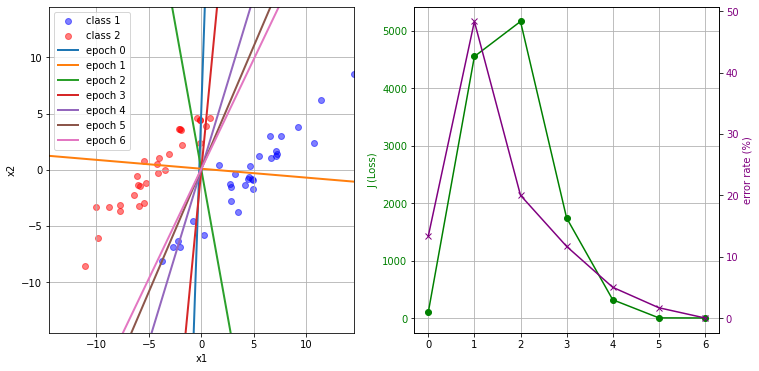

In [9]:
w_hats, Js, error_rates = perceptron_learning(x, labels, w_nm, eta=1)
plot_linear_learning(x, labels, w_hats, Js, error_rates)

We can even animate this to see how the algorithm learns!  I used this [tutorial](https://towardsdatascience.com/learn-how-to-create-animated-graphs-in-python-fce780421afe).

In [6]:
def create_animated_learning(x, labels, w_hats, Js, error_rates, fname, display_interval=100):
    fig_to_animate, ax = plt.subplots(1, 2, sharex=False, figsize=(12, 6))
    ## scatter plot with deciscion boundaries
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].grid(':')
    LIMIT = np.max(x)
    ax[0].set_xlim([-LIMIT, LIMIT])
    ax[0].set_ylim([-LIMIT, LIMIT])

    ## Learning curve
    ax2 = ax[1].twinx() 
    ax[1].set_ylabel('J (Loss)', color = 'green') 
    ax[1].tick_params(axis ='y', labelcolor = 'green') 
    ax2.set_ylabel('Error rate (%)', color = 'purple') 
    ax2.tick_params(axis ='y', labelcolor = 'purple') 
    # ax2.set_ylabel('error rate (%)')
    ax2.set_ylim([0,100])
    ax[1].grid(':')

    def animate_plot(epoch):
        w_hat = w_hats[epoch]
        x_1 = x[labels==1]
        x_2 = x[labels==2]
      
        ## scatter plot with deciscion boundaries
        LIMIT = np.max(x)
        x_plot = np.arange(-1 * LIMIT, LIMIT, 0.01)
        ax[0].scatter(x_1.T[0], x_1.T[1], fc=(0, 0, 1, 0.5), label='class 1')
        ax[0].scatter(x_2.T[0], x_2.T[1], fc=(1, 0, 0, 0.5), label='class 2')
        
        ax[0].plot( x_plot, -1 * ( w_hat[1] *  x_plot  + w_hat[0] ) / w_hat[2], linewidth=2, label=f'epoch {epoch}')

        ## Learning curve
        epochs = np.arange(epoch)
        ax[1].plot(epochs, Js[:epoch], marker='o', color='green', label='J (Loss)')
        # add second y-axis for the metric of error rate: https://pythonguides.com/matplotlib-two-y-axes/
        ax2.plot(epochs, error_rates[:epoch] * 100, marker='x', color='purple', label='Error Rate')

    import matplotlib.animation as ani
    animator = ani.FuncAnimation(fig_to_animate, animate_plot, frames=np.arange(len(Js)), interval=display_interval)
    animator.save(fname)

MovieWriter ffmpeg unavailable; using Pillow instead.


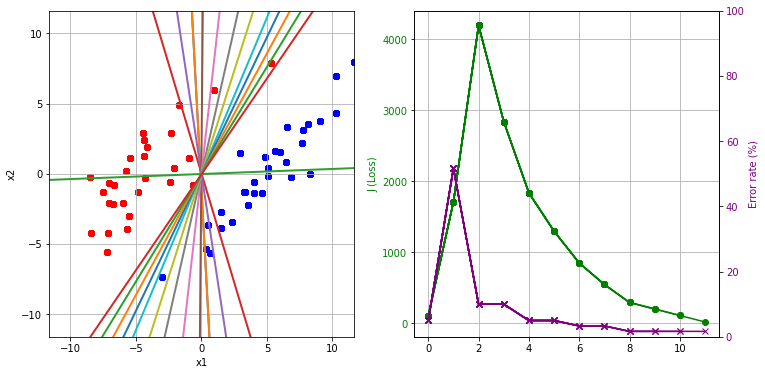

In [7]:
create_animated_learning(x, labels, w_hats, Js, error_rates, 'img/perceptron1.gif', display_interval=500)

![](./img/perceptron12.gif)

Notice in the above, the first change in the decision boundary makes the loss larger!  This suggests a smaller learning rate may be better.  

Let's try it with learning rate $\eta = 0.25$:

epoch 0	errors: 3	J: 106.27931982805868	w_hat:[ 0.56708092 10.04303521  0.5807963 ]
epoch 1	errors: 1	J: 4.1085120522762395	w_hat:[ 0.31708092  7.71868843 -4.73012439]
epoch 2	errors: 1	J: 1.2993971935221458	w_hat:[ 0.06708092  6.38784296 -6.70143063]
epoch 3	errors: 1	J: 0.7693445015032152	w_hat:[-0.18291908  6.55489062 -6.49622768]
epoch 4	errors: 1	J: 0.23929180948428552	w_hat:[-0.43291908  6.72193829 -6.29102473]
epoch 5	errors: 0	J: -0.0	w_hat:[-0.68291908  6.88898596 -6.08582179]
epoch 6	errors: 0	J: -0.0	w_hat:[-0.68291908  6.88898596 -6.08582179]


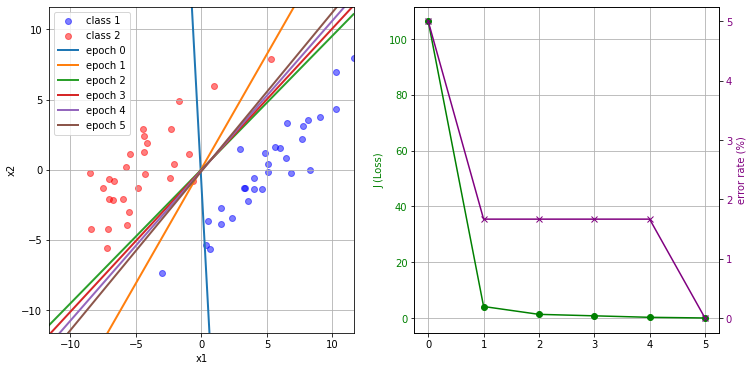

In [8]:
w_hats, Js, error_rates = perceptron_learning(x, labels, w_nm, eta=0.25)
plot_linear_learning(x, labels, w_hats, Js, error_rates)

**Suggestion** Use these routines to generate other data examples and gain intuition.  Here are some questions:
- What happens with the data is not linearly separable?  Is the LS classifier better in this case?  Always?
- Explore how the learning rate affects the convergence of the perceptron learning algorithm.
- What if you genereated another dataset with the same statistics and used this as the test set?  Would you get the same misclassification rate?
- Suppose there are many more points in class 1 than there are in class 2.  Can this impact the decisions for the LS classifier?  How about the perceptron classifier?
- Does the perceptron learning algorithm alsways yield a decision boundary that is maximally distant from the data?  What about the LS classifier?

**Python Tips/Questions (from `perceptron_learning`):**
- Why am I using `np.copy()1 when storing the weights?
- How did I determine decisions -- i.e., how did I compute if there were errors?  
- What does `zx = (x_aug.T * z).T` do?
- 